In [2]:
import numpy as np
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix
import time
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
le = LabelEncoder()

from google.colab import drive
drive.mount('/content/drive')

from google.colab import drive
drive.mount('/content/drive')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
label="y"

In [5]:
train_data = pd.read_csv('/content/drive/MyDrive/MLLab/train.csv')

In [6]:
valid_data = pd.read_csv('/content/drive/MyDrive/MLLab/valid.csv')

In [7]:
test_data = pd.read_csv('/content/drive/MyDrive/MLLab/test.csv')

In [8]:
print("Train Data")
for i in range(4):
  X_train_with_y = train_data.iloc[:, :256]
  X_train_with_y[label] = train_data.iloc[:,-4+i]
  rows_with_nan = X_train_with_y[X_train_with_y.isna().any(axis=1)]
  nan_row_percentage = rows_with_nan.shape[0]*100/X_train_with_y.shape[0]
  print("Missing values row percentage for %s : %f%%" %(train_data.columns[-4+i],nan_row_percentage))

Train Data
Missing values row percentage for label_1 : 0.000000%
Missing values row percentage for label_2 : 1.683029%
Missing values row percentage for label_3 : 0.000000%
Missing values row percentage for label_4 : 0.000000%


In [9]:
print("Valid Data")
for i in range(4):
  X_valid_with_y = valid_data.iloc[:, :256]
  X_valid_with_y[label] = valid_data.iloc[:,-4+i]
  rows_with_nan = X_valid_with_y[X_valid_with_y.isna().any(axis=1)]
  nan_row_percentage = rows_with_nan.shape[0]*100/X_valid_with_y.shape[0]
  print("Missing values row percentage for %s : %f%%" %(valid_data.columns[-4+i],nan_row_percentage))

Valid Data
Missing values row percentage for label_1 : 0.000000%
Missing values row percentage for label_2 : 1.866667%
Missing values row percentage for label_3 : 0.000000%
Missing values row percentage for label_4 : 0.000000%


Since the training dataset is very large and the missing values rows percentage is low for label 2 column, missing values rows are removed. Since there are no other missing values in other columns, there are no changes done to them

In [10]:
missing_removed_X = []
missing_removed_y = []
for i in range(4):
  X_train_with_y = train_data.iloc[:, :256]
  X_train_with_y[label] = train_data.iloc[:,-4+i]
  X_train_with_y = X_train_with_y.dropna()
  missing_removed_X.append(X_train_with_y.iloc[:, :256])
  missing_removed_y.append(X_train_with_y.iloc[:,-1].to_frame(name=label))

In [11]:
print("Shapes after removing the missing values rows in train data")
for i in range(4):
  print("X train shape :", missing_removed_X[i].shape)
  print("Y train shape :", missing_removed_y[i].shape)

Shapes after removing the missing values rows in train data
X train shape : (28520, 256)
Y train shape : (28520, 1)
X train shape : (28040, 256)
Y train shape : (28040, 1)
X train shape : (28520, 256)
Y train shape : (28520, 1)
X train shape : (28520, 256)
Y train shape : (28520, 1)


In [12]:
missing_removed_X_valid = []
missing_removed_y_valid = []
for i in range(4):
  X_valid_with_y = valid_data.iloc[:, :256]
  X_valid_with_y[label] = valid_data.iloc[:,-4+i]
  X_valid_with_y = X_valid_with_y.dropna()
  missing_removed_X_valid.append(X_valid_with_y.iloc[:, :256])
  missing_removed_y_valid.append(X_valid_with_y.iloc[:,-1].to_frame(name=label))

In [13]:
print("Shapes after removing the missing values rows in valid data")
for i in range(4):
  print("X valid shape :", missing_removed_X_valid[i].shape)
  print("Y valid shape :", missing_removed_y_valid[i].shape)

Shapes after removing the missing values rows in valid data
X valid shape : (750, 256)
Y valid shape : (750, 1)
X valid shape : (736, 256)
Y valid shape : (736, 1)
X valid shape : (750, 256)
Y valid shape : (750, 1)
X valid shape : (750, 256)
Y valid shape : (750, 1)


In [14]:
X_train_arr = [missing_removed_X[i] for i in range(4)]
X_valid_arr = [missing_removed_X_valid[i] for i in range(4)]
X_test_arr = [test_data.iloc[:,:256] for i in range(4)]
y_train_arr = missing_removed_y
y_valid_arr = missing_removed_y_valid

In [15]:
def visualize_y(y, labelName):
  unique_classes, class_counts = np.unique(y, return_counts=True)
  plt.bar(unique_classes, class_counts)
  plt.xlabel(labelName)
  plt.ylabel('Number of samples')
  plt.title('Label Distribution')
  plt.show()

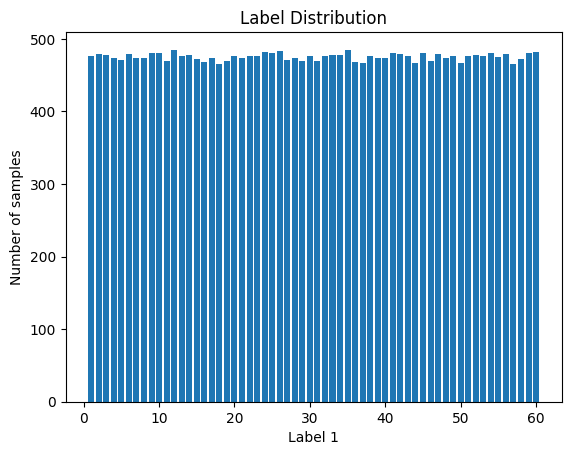

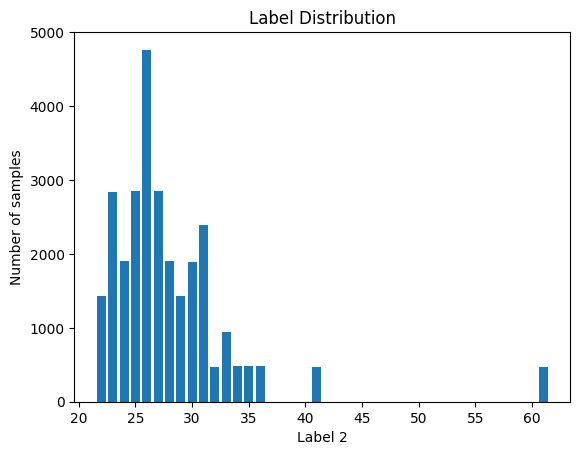

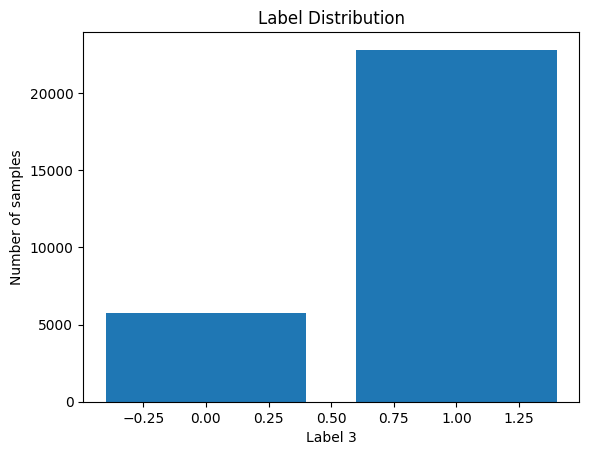

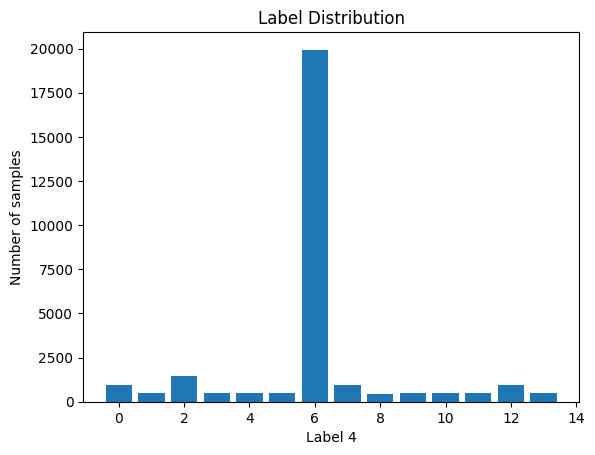

In [16]:
for i in range(4):
  visualize_y(y_train_arr[i], f'Label {i+1}')

As in above graph, the label 4 column is not equally distributed. Thereofore it is sampled to have a uniform distribution.

In [17]:
sampler = RandomOverSampler(random_state=40)
sampled = sampler.fit_resample(X_train_arr[3], y_train_arr[3][label])
X_train_arr[3], y_train_arr[3] = sampled[0],sampled[1].to_frame(name=label)
print("Afte the resampling")
print("X train(Label 4) shape :", X_train_arr[3].shape)
print("Y train(Label 4) shape :", y_train_arr[3].shape)

Afte the resampling
X train(Label 4) shape : (279132, 256)
Y train(Label 4) shape : (279132, 1)


In [18]:
def findAccuracy(y_predicted, y_correct):
  accuracy = accuracy_score(y_predicted, y_correct)
  return accuracy

In [19]:
def xgBoost(X, y):
  num_classes = len(y[label].unique())
  if num_classes == 2:
    objective = 'binary:logistic'
  else:
    objective = 'multi:softmax'
  model = xgb.XGBClassifier(objective=objective, random_state=40, tree_method='gpu_hist')
  y_encoded = le.fit_transform(y[label])
  model.fit(X, y_encoded)
  return model
def xgBoostPredict(X, model):
  y_pred_encoded = model.predict(X)
  y_pred = le.inverse_transform(y_pred_encoded)
  return y_pred
def carryOutXGBoost(X_train_arr,y_train_arr, X_valid_arr, y_valid_arr, X_test_arr):
  y_pred_test_arr = []
  for i in range(4):
    print("XGBoost For the ", train_data.columns[-4+i])
    model = xgBoost(X_train_arr[i], y_train_arr[i])
    y_pred_valid = xgBoostPredict(X_valid_arr[i], model)
    xgBoostValidAccuracy = findAccuracy(y_pred_valid, y_valid_arr[i])
    y_pred_test = xgBoostPredict(X_test_arr[i], model)
    y_pred_test_arr.append(y_pred_test)
    print("Valid Accuracy : ",xgBoostValidAccuracy)
    print()
  return y_pred_test_arr

In [20]:
def randomForest(X, y):
  model = RandomForestClassifier(random_state=40)
  y_encoded = le.fit_transform(y[label])
  model.fit(X, y_encoded)
  return model
def randomForestPredict(X, model):
  y_pred_encoded = model.predict(X)
  y_pred = le.inverse_transform(y_pred_encoded)
  return y_pred
def carryOutRandomForest(X_train_arr,y_train_arr, X_valid_arr, y_valid_arr,X_test_arr):
  y_pred_test_arr = []
  for i in range(4):
    print("Random Forest For the ", train_data.columns[-4+i])
    model = randomForest(X_train_arr[i], y_train_arr[i])
    y_pred_valid = randomForestPredict(X_valid_arr[i], model)
    randomForestValidAccuracy = findAccuracy(y_pred_valid, y_valid_arr[i])
    y_pred_test = randomForestPredict(X_test_arr[i], model)
    y_pred_test_arr.append(y_pred_test)
    print("Valid Accuracy : ",randomForestValidAccuracy)
    print()
  return y_pred_test_arr

In [21]:
def svm(X, y):
  num_classes = len(y[label].unique())
  if num_classes == 2:
    model = SVC(kernel='rbf', random_state=40)
  else:
    model = SVC(kernel='rbf', decision_function_shape='ovr', random_state=40)
  y_encoded = le.fit_transform(y[label])
  model.fit(X, y_encoded)
  return model
def svmPredict(X, model):
  y_pred_encoded = model.predict(X)
  y_pred = le.inverse_transform(y_pred_encoded)
  return y_pred
def carryOutSVM(X_train_arr,y_train_arr, X_valid_arr, y_valid_arr, X_test_arr):
  y_pred_test_arr = []
  for i in range(4):
    print("SVM For the ", train_data.columns[-4+i])
    svmModel = svm(X_train_arr[i], y_train_arr[i])
    y_pred_valid = svmPredict(X_valid_arr[i], svmModel)
    svmValidAccuracy = findAccuracy(y_pred_valid, y_valid_arr[i])
    print("Valid Accuracy : ", svmValidAccuracy)
    y_pred_test = svmPredict(X_test_arr[i], svmModel)
    y_pred_test_arr.append(y_pred_test)
    print()
  return y_pred_test_arr

In [22]:
y_pred_XGBoost_before_reduction = carryOutXGBoost(X_train_arr,y_train_arr, X_valid_arr, y_valid_arr, X_test_arr)

XGBoost For the  label_1
Valid Accuracy :  0.9413333333333334

XGBoost For the  label_2
Valid Accuracy :  0.9578804347826086

XGBoost For the  label_3
Valid Accuracy :  0.9973333333333333

XGBoost For the  label_4
Valid Accuracy :  0.984



In [23]:
y_pred_random_forest_before_reduction = carryOutRandomForest(X_train_arr,y_train_arr, X_valid_arr, y_valid_arr, X_test_arr)

Random Forest For the  label_1
Valid Accuracy :  0.9653333333333334

Random Forest For the  label_2
Valid Accuracy :  0.9279891304347826

Random Forest For the  label_3
Valid Accuracy :  0.9946666666666667

Random Forest For the  label_4
Valid Accuracy :  0.896



In [24]:
y_pred_svm_before_reduction = carryOutSVM(X_train_arr,y_train_arr, X_valid_arr, y_valid_arr, X_test_arr)

SVM For the  label_1
Valid Accuracy :  0.992

SVM For the  label_2
Valid Accuracy :  0.9769021739130435

SVM For the  label_3
Valid Accuracy :  1.0

SVM For the  label_4
Valid Accuracy :  0.9933333333333333



In [25]:
def getCorelationFeatureIndexesToRemove(X, y,  corelation_threshold=0.7):
  length_X = X.shape[1]
  train_data = X.copy()
  train_data = train_data.assign(y=y)
  correlation_matrix = train_data.corr()
  highly_correlated = np.where(np.abs(correlation_matrix) > corelation_threshold)
  features_to_remove = set()
  for i, j in zip(*highly_correlated):
    if i != j and (i not in features_to_remove or j not in features_to_remove) and i<length_X and j<length_X:
        corr_iy = correlation_matrix.iloc[i, length_X]
        corr_jy = correlation_matrix.iloc[j, length_X]
        remove_column_index =  i if corr_iy>corr_jy else j
        features_to_remove.add(remove_column_index)
  return features_to_remove


In [26]:
def removeCorelatedColumns(X, features_to_remove):
  return X.drop(columns=set([X.columns[i] for i in features_to_remove]))

In [27]:
features_to_remove_arr = [getCorelationFeatureIndexesToRemove(X_train_arr[i],y_train_arr[i], 0.5) for i in range(4)]

In [28]:
X_train_arr = [removeCorelatedColumns(X_train_arr[i], features_to_remove_arr[i]) for i in range(4)]
X_valid_arr = [removeCorelatedColumns(X_valid_arr[i], features_to_remove_arr[i]) for i in range(4)]
X_test_arr = [removeCorelatedColumns(X_test_arr[i], features_to_remove_arr[i]) for i in range(4)]

In [29]:
print("Shapes after reducing the correlated features in train data")
for i in range(4):
  print("X train shape :", X_train_arr[i].shape)
print()
print("Shapes after reducing the correlated features in valid data")
for i in range(4):
  print("X valid shape :", X_valid_arr[i].shape)
print()
print("Shapes after reducing the correlated features in test data")
for i in range(4):
  print("X test shape :", X_test_arr[i].shape)

Shapes after reducing the correlated features in train data
X train shape : (28520, 192)
X train shape : (28040, 195)
X train shape : (28520, 195)
X train shape : (279132, 178)

Shapes after reducing the correlated features in valid data
X valid shape : (750, 192)
X valid shape : (736, 195)
X valid shape : (750, 195)
X valid shape : (750, 178)

Shapes after reducing the correlated features in test data
X test shape : (750, 192)
X test shape : (750, 195)
X test shape : (750, 195)
X test shape : (750, 178)


In [30]:
y_pred_XGBoost_after_correlation_reduction = carryOutXGBoost(X_train_arr,y_train_arr, X_valid_arr, y_valid_arr, X_test_arr)

XGBoost For the  label_1
Valid Accuracy :  0.9346666666666666

XGBoost For the  label_2
Valid Accuracy :  0.9497282608695652

XGBoost For the  label_3
Valid Accuracy :  0.996

XGBoost For the  label_4
Valid Accuracy :  0.972



In [31]:
y_pred_random_forest_after_correlation_reduction = carryOutRandomForest(X_train_arr,y_train_arr, X_valid_arr, y_valid_arr, X_test_arr)

Random Forest For the  label_1
Valid Accuracy :  0.9746666666666667

Random Forest For the  label_2
Valid Accuracy :  0.9279891304347826

Random Forest For the  label_3
Valid Accuracy :  0.9933333333333333

Random Forest For the  label_4
Valid Accuracy :  0.8826666666666667



In [32]:
y_pred_svm_after_correlation_reduction = carryOutSVM(X_train_arr,y_train_arr, X_valid_arr, y_valid_arr, X_test_arr)

SVM For the  label_1
Valid Accuracy :  0.9906666666666667

SVM For the  label_2
Valid Accuracy :  0.96875

SVM For the  label_3
Valid Accuracy :  1.0

SVM For the  label_4
Valid Accuracy :  0.9933333333333333



In [33]:
desired_variance_ratio = 0.95
pca_arr = [PCA(n_components=desired_variance_ratio, svd_solver='full') for i in range(4)]
def pcaFunc(X,pca, firstFit=False):
  feature_names = X.columns
  if firstFit:
    X_train_pca = pca.fit_transform(X)
  else:
    X_train_pca = pca.transform(X)
  return pd.DataFrame(data=X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])

In [34]:
X_train_arr = [pcaFunc(X_train_arr[i],pca_arr[i], firstFit=True) for i in range(4)]
X_valid_arr = [pcaFunc(X_valid_arr[i],pca_arr[i]) for i in range(4)]
X_test_arr = [pcaFunc(X_test_arr[i],pca_arr[i]) for i in range(4)]

In [35]:
print("Shapes after reducing the features in train data")
for i in range(4):
  print("X train shape :", X_train_arr[i].shape)
print()
print("Shapes after reducing the features in valid data")
for i in range(4):
  print("X valid shape :", X_valid_arr[i].shape)
print()
print("Shapes after reducing the features in test data")
for i in range(4):
  print("X test shape :", X_test_arr[i].shape)

Shapes after reducing the features in train data
X train shape : (28520, 63)
X train shape : (28040, 64)
X train shape : (28520, 64)
X train shape : (279132, 62)

Shapes after reducing the features in valid data
X valid shape : (750, 63)
X valid shape : (736, 64)
X valid shape : (750, 64)
X valid shape : (750, 62)

Shapes after reducing the features in test data
X test shape : (750, 63)
X test shape : (750, 64)
X test shape : (750, 64)
X test shape : (750, 62)


In [36]:
print("Accuracies after feature reduction")

Accuracies after feature reduction


In [37]:
y_pred_XGBoost_after_reduction = carryOutXGBoost(X_train_arr,y_train_arr, X_valid_arr, y_valid_arr, X_test_arr)

XGBoost For the  label_1
Valid Accuracy :  0.932

XGBoost For the  label_2
Valid Accuracy :  0.9171195652173914

XGBoost For the  label_3
Valid Accuracy :  1.0

XGBoost For the  label_4
Valid Accuracy :  0.948



In [38]:
y_pred_random_forest_after_reduction = carryOutRandomForest(X_train_arr,y_train_arr, X_valid_arr, y_valid_arr, X_test_arr)

Random Forest For the  label_1
Valid Accuracy :  0.9626666666666667

Random Forest For the  label_2
Valid Accuracy :  0.9130434782608695

Random Forest For the  label_3
Valid Accuracy :  0.9893333333333333

Random Forest For the  label_4
Valid Accuracy :  0.8613333333333333



In [39]:
y_pred_svm_after_reduction = carryOutSVM(X_train_arr,y_train_arr, X_valid_arr, y_valid_arr,  X_test_arr)

SVM For the  label_1
Valid Accuracy :  0.9893333333333333

SVM For the  label_2
Valid Accuracy :  0.9809782608695652

SVM For the  label_3
Valid Accuracy :  1.0

SVM For the  label_4
Valid Accuracy :  0.992



Since the SVM model results have the highest accuracy, it is selected for preparing the final CSVs.

In [40]:
def createCSVOutput(y_pred, y_pred_after_reduction, X_reduced, labelNo):
  data = {
    'Predicted labels before feature engineering': y_pred,
    'Predicted labels after feature engineering': y_pred_after_reduction,
    'No of new features': [X_reduced.shape[1]] * len(y_pred),
  }
  for i in range(X_reduced.shape[1]):
    data[f'new_feature_{i+1}'] = X_reduced.iloc[:, i]
  for i in range(X_reduced.shape[1], 256):
        data[f'new_feature_{i+1}'] = [0] * len(y_pred)
  df = pd.DataFrame(data)
  filename = f'/content/drive/MyDrive/MLLab/label{labelNo+1}.csv'
  df.to_csv(filename, index=False)

In [41]:
for i in range(4):
  createCSVOutput(y_pred_svm_before_reduction[i], y_pred_svm_after_reduction[i], X_test_arr[i], i)